# FAG2 Demo

## libraries

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import torch.utils.data as data
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets import MNIST
from PIL import Image

import numpy as np
import datetime
import os, sys

from matplotlib.pyplot import imshow
%matplotlib inline

In [2]:
dataset = 'mnist'
datadir = './data'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_noise = 100
batch_size = 32

num_epochs = 10
num_rounds = 10
n_parties = 10

## Data

In [3]:
class MNIST_truncated(data.Dataset):

    def __init__(self, root, dataidxs=None, train=True, transform=None, target_transform=None, download=False):

        self.root = root
        self.dataidxs = dataidxs
        self.train = train
        self.transform = transform
        self.target_transform = target_transform
        self.download = download

        self.data, self.target = self.__build_truncated_dataset__()

    def __build_truncated_dataset__(self):

        mnist_dataobj = MNIST(self.root, self.train, self.transform, self.target_transform, self.download)

        data = mnist_dataobj.data
        target = mnist_dataobj.targets

        if self.dataidxs is not None:
            data = data[self.dataidxs]
            target = target[self.dataidxs]

        return data, target

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], self.target[index]

        # doing this so that it is consistent with all other datasets to return a PIL Image
        img = Image.fromarray(img.numpy(), mode='L')

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return len(self.data)

In [4]:
def load_mnist_data(datadir):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.5], std=[0.5])])

    mnist_train_ds = MNIST_truncated(datadir, train=True, download=True, transform=transform)
    mnist_test_ds = MNIST_truncated(datadir, train=False, download=True, transform=transform)

    X_train, y_train = mnist_train_ds.data, mnist_train_ds.target
    X_test, y_test = mnist_test_ds.data, mnist_test_ds.target

    X_train = X_train.data.numpy()
    y_train = y_train.data.numpy()
    X_test = X_test.data.numpy()
    y_test = y_test.data.numpy()

    return X_train, y_train, X_test, y_test

def partition_data(datadir, n_parties, beta=0.4):
    X_train, y_train, X_test, y_test = load_mnist_data(datadir)
    N = y_train.shape[0]
    K = 10

    net_dataidx_map = {}
    min_size = 0
    min_required_size = 10
    while min_size < min_required_size:
        idx_batch = [[] for _ in range(n_parties)]
        for k in range(K):
            idx_k = np.where(y_train == k)[0]
            np.random.shuffle(idx_k)
            proportions = np.random.dirichlet(np.repeat(beta, n_parties))

            ## Balance
            proportions = np.array([p * (len(idx_j) < N / n_parties) for p, idx_j in zip(proportions, idx_batch)])
            proportions = proportions / proportions.sum()
            proportions = (np.cumsum(proportions) * len(idx_k)).astype(int)[:-1]

            idx_batch = [idx_j + idx.tolist() for idx_j, idx in zip(idx_batch, np.split(idx_k, proportions))]
            min_size = min([len(idx_j) for idx_j in idx_batch])

        for j in range(n_parties):
            np.random.shuffle(idx_batch[j])
            net_dataidx_map[j] = idx_batch[j]

    traindata_cls_counts = {}

    for net_i, dataidx in net_dataidx_map.items():
        unq, unq_cnt = np.unique(y_train[dataidx], return_counts=True)
        traindata_cls_counts[net_i] = {unq[i]: unq_cnt[i] for i in range(len(unq))}

    return X_train, y_train, X_test, y_test, net_dataidx_map, traindata_cls_counts

In [5]:
def get_dataloader(dataset, datadir, dataidxs=None):
    transform_train = transforms.Compose([transforms.ToTensor(), ])
    transform_test = transforms.Compose([transforms.ToTensor(), ])

    train_ds = MNIST_truncated(datadir, dataidxs=dataidxs, train=True, transform=transform_train, download=True)
    test_ds  = MNIST_truncated(datadir, train=False, transform=transform_test, download=True)
    train_dl = data.DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True, drop_last=False)
    test_dl  = data.DataLoader(dataset=test_ds, batch_size=batch_size, shuffle=False, drop_last=False)

    return train_dl, test_dl

## Model

### Generator

In [6]:
class Generator(nn.Module):
    """
        Simple Generator w/ MLP
    """
    def __init__(self, input_size=100, num_classes=784):
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, num_classes),
            nn.Tanh()
        )
        
    def forward(self, x):
        y_ = self.layer(x)
        y_ = y_.view(x.size(0), 1, 28, 28)
        return y_

### Discriminator

In [7]:
class Discriminator(nn.Module):
    """
        Simple Discriminator w/ MLP
    """
    def __init__(self, input_size=784, num_classes=1):
        super(Discriminator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, num_classes),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        y_ = x.view(x.size(0), -1)
        y_ = self.layer(y_)
        return y_

## Train

In [8]:
def train_local_discriminator(local_d, opt_d, local_g, images):
    local_d.to(device)
    local_g.to(device)
    criterion = torch.nn.BCELoss()

    x = images.to(device)
    x_outputs = local_d(x)
    d_labels = torch.ones(x.shape[0], 1).to(device)
    x_loss = criterion(x_outputs, d_labels)

    z = torch.randn(x.shape[0], n_noise).to(device)
    z_outputs = local_d(local_g(z))
    d_fakes = torch.zeros(x.shape[0], 1).to(device)
    z_loss = criterion(z_outputs, d_fakes)
    d_loss = x_loss + z_loss
        
    local_d.zero_grad()
    d_loss.backward()
    opt_d.step()

    return d_loss
    

In [9]:
def fedavg(local_nets):
    # do fedavg on local nets
    total_data_points = sum([len(net_dataidx_map[r]) for r in range(len(local_nets))])
    fed_avg_freqs = [len(net_dataidx_map[r]) / total_data_points for r in range(len(local_nets))]

    fedavg_g = Generator()
    fedavg_param = fedavg_g.state_dict()
    for idx in range(len(local_nets)):
        local_param = local_nets[idx].cpu().state_dict()
        if idx == 0:
            for key in local_param:
                fedavg_param[key] = local_param[key] * fed_avg_freqs[idx]
        else:
            for key in local_param:
                fedavg_param[key] += local_param[key] * fed_avg_freqs[idx]
    fedavg_g.load_state_dict(fedavg_param)
    return fedavg_g

In [10]:
def train_local_generator(local_d, local_g, opt_g, N):
    local_d.to(device)
    local_g.to(device)
    criterion = nn.BCELoss()

    z = torch.randn(N, n_noise).to(device)
    z_outputs = local_d(local_g(z))
    d_labels = torch.ones(N, 1).to(device)
    loss = criterion(z_outputs, d_labels)

    local_g.zero_grad()
    loss.backward()
    opt_g.step()

    return loss


## Main

In [11]:
def get_sample_image(G, n_noise):
    """
        save sample 100 images
    """
    z = torch.randn(100, n_noise).to(device)
    y_hat = G(z).view(100, 28, 28) # (100, 28, 28)
    result = y_hat.cpu().data.numpy()
    img = np.zeros([280, 280])
    for j in range(10):
        img[j*28:(j+1)*28] = np.concatenate([x for x in result[j*10:(j+1)*10]], axis=-1)
    return img

In [13]:
# data
_, _, _, _, net_dataidx_map, traindata_cls_counts = partition_data("./data", n_parties)

datamap = {}
for i in range(n_parties):
    dataidxs = net_dataidx_map[i]
    dataloader, _ = get_dataloader(dataset, datadir, dataidxs)
    datamap[i] = dataloader

# init local nets
local_discriminators = {}
local_generators = {}
local_d_optimizers = {}
local_g_optimizers = {}
for i in range(n_parties):
    local_discriminators[i] = Discriminator().to(device)
    local_d_optimizers[i] = torch.optim.Adam(local_discriminators[i].parameters(), lr=0.0002, betas=(0.5, 0.999))
    local_generators[i] = Generator().to(device)
    local_g_optimizers[i] = torch.optim.Adam(local_generators[i].parameters(), lr=0.0002, betas=(0.5, 0.999))
global_g = Generator().to(device)

# init parameter
global_param = global_g.state_dict()
for i in range(n_parties):
    local_generators[i].load_state_dict(global_param)

# training
step = 0
for round in range(num_rounds):
    for i in range(n_parties):
        for epoch in range(num_epochs):
            d_losses, g_losses = [], []
            for batch_idx, (images, _) in enumerate(datamap[i]):
                d_loss = train_local_discriminator(local_discriminators[i], local_d_optimizers[i], local_generators[i], images)
                g_loss = train_local_generator(local_discriminators[i], local_generators[i], local_g_optimizers[i], images.shape[0])
                d_losses.append(d_loss.data.item())
                g_losses.append(g_loss.data.item())
                step += 1
            print(f"epoch: {round}/{num_rounds}, step: {step}, d_loss: {sum(d_losses)/len(d_losses)}, g_loss: {sum(g_losses)/len(g_losses)}")

    global_g = fedavg(local_generators)

    global_param = global_g.state_dict()
    for i in range(n_parties):
        local_generators[i].load_state_dict(global_param)     



epoch: 0/10, step: 219, d_loss: 1.2899576213261852, g_loss: 1.0717029351077667
epoch: 0/10, step: 438, d_loss: 1.1899494188561288, g_loss: 1.5635874015555533
epoch: 0/10, step: 657, d_loss: 1.0765966334843744, g_loss: 2.2199435772961134
epoch: 0/10, step: 876, d_loss: 1.173452043642192, g_loss: 2.0650558771063747
epoch: 0/10, step: 1095, d_loss: 1.1673505807031779, g_loss: 1.9637407962590048
epoch: 0/10, step: 1314, d_loss: 1.1305612162367937, g_loss: 1.9661433274887468
epoch: 0/10, step: 1533, d_loss: 1.1224884292850756, g_loss: 2.1924480259690653
epoch: 0/10, step: 1752, d_loss: 1.1309651917518546, g_loss: 1.9534221588204441
epoch: 0/10, step: 1971, d_loss: 1.1404914259910583, g_loss: 1.9319006582917688
epoch: 0/10, step: 2190, d_loss: 1.1672700975583568, g_loss: 1.6622390025826894
epoch: 0/10, step: 2371, d_loss: 1.3016715846667632, g_loss: 1.0612482227673188
epoch: 0/10, step: 2552, d_loss: 1.238235719296155, g_loss: 1.3258256467666416
epoch: 0/10, step: 2733, d_loss: 1.06326887719

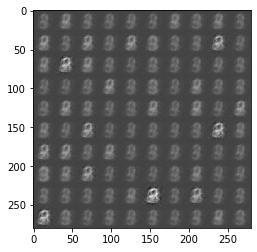

In [14]:
global_g.eval()
global_g.to(device)
imshow(get_sample_image(global_g, n_noise), cmap='gray')